In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from io import BytesIO
from IPython.display import display, Image
from PIL import Image as PILImage
import requests
import json
import pandas as pd

In [3]:
PROJECT_SUBDIR = r'/Develop/TrailSight'
COLAB_PATH = '/content/drive/MyDrive'
BASE_PATH = COLAB_PATH
PROJECT_DIR = BASE_PATH + PROJECT_SUBDIR
MODEL_PATH = PROJECT_DIR + 'model_weights.pth'

In [4]:
def load_metadata(metadata_path: str):
  with open(metadata_path, 'r') as f:
      metadata = json.load(f)
  return metadata

In [5]:
metadata = load_metadata(f"{PROJECT_DIR}/idaho-camera-traps.json")
categoeries = pd.DataFrame(metadata['categories'])
annotations = pd.DataFrame(metadata['annotations'])
images = pd.DataFrame(metadata['images'])
images_annotations = pd.merge(annotations, images, left_on='image_id', right_on='id', how='inner', suffixes=('_annotation', '_img'))
images_annotations = images_annotations[~images_annotations['category_id'].isin([29, 1, 48, 32, 26,	34 ,54])].reset_index(drop=True)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    images_annotations,
    test_size=0.2,
    stratify=images_annotations['category_id'],
    random_state=42
)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class AnimalsDataset(Dataset):
    def __init__(self, images: pd.DataFrame, labels: pd.DataFrame):
      self.categoeries = labels # this is not y, it simply maps the class id to name
      self.images_annotations = images # x, y and other metadata
      self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
      ])

    def fetch_image(self, idx):
      path = self.images_annotations.iloc[idx]['file_name']
      gcp_url = f"https://storage.googleapis.com/public-datasets-lila/idaho-camera-traps/public/{path}"
      aws_url = f"http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/idaho-camera-traps/public/{path}"
      azure_url = f"https://lilawildlife.blob.core.windows.net/lila-wildlife/idaho-camera-traps/public/{path}"
      urls = [gcp_url, aws_url, azure_url]

      for url in urls:
        try:
          response = requests.get(url, timeout=5)
          if response.status_code == 200:
            img_data = response.content
            return self.transform(PILImage.open(BytesIO(img_data))), self.images_annotations.iloc[idx]['category_id']
        except Exception as e:
          continue

      return self.create_placeholder_image(path)

    def create_placeholder_image(self, path):
      print(f"WARNING Image not found. {path}. Defaulting to empty image.")
      return torch.load("/content/drive/MyDrive/Develop/mean_image_tensor.pt"), np.int64(0)

    def __len__(self):
      return len(self.images_annotations)

    def __getitem__(self, idx):
      return self.fetch_image(idx)

    def idx_to_class(self, idx):
      if idx > len(self.categoeries):
        raise Exception("Index out of range")
      return self.categoeries.loc[idx, 'name']

In [7]:
train_data = AnimalsDataset(train_df, categoeries)

In [8]:
from collections import Counter
labels = train_data.images_annotations['category_id'].tolist()
class_counts = Counter(labels)

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]

from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_data,
    batch_size=10,
    sampler=sampler
)

from collections import Counter

for imgs, labels in train_loader:
    label_names = [train_data.idx_to_class(int(lbl)) for lbl in labels]
    print(Counter(label_names))
    break

Counter({'moose': 2, 'porcupine': 1, 'deer': 1, 'bear': 1, 'fox': 1, 'misdirected': 1, 'hawk': 1, 'unknown cervid': 1, 'turkey': 1})


In [10]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models

device = torch.device("cuda")
num_classes = train_data.categoeries['id'].nunique()

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

resume_training = True

if resume_training:
  model.load_state_dict(torch.load(MODEL_PATH))

model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torch.save(model.state_dict(), MODEL_PATH)

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(5):
    model.train()
    batch = 1
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"\tBatch {batch}, Loss: {loss.item():.4f}")
        batch += 1
        if batch % 20 == 0: torch.save(model.state_dict(), MODEL_PATH)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

WARNING Image not found. loc_0182/loc_0182_im_000003.jpg. Defaulting to empty image.
	Batch 1, Loss: 0.7774
	Batch 2, Loss: 0.2673
	Batch 3, Loss: 1.4891
	Batch 4, Loss: 0.2700
	Batch 5, Loss: 0.7556
	Batch 6, Loss: 0.3580
	Batch 7, Loss: 0.2217
WARNING Image not found. loc_0171/loc_0171_im_001264.jpg. Defaulting to empty image.
	Batch 8, Loss: 0.3460
	Batch 9, Loss: 1.0195
	Batch 10, Loss: 0.9826
	Batch 11, Loss: 0.3702
	Batch 12, Loss: 0.2917
	Batch 13, Loss: 0.0517
	Batch 14, Loss: 0.8481
	Batch 15, Loss: 0.5316
	Batch 16, Loss: 0.5470
	Batch 17, Loss: 0.9560
	Batch 18, Loss: 0.4913
WARNING Image not found. loc_0265/loc_0265_im_004197.jpg. Defaulting to empty image.
	Batch 19, Loss: 0.5654
	Batch 20, Loss: 0.0066
WARNING Image not found. loc_0121/loc_0121_im_000391.jpg. Defaulting to empty image.
	Batch 21, Loss: 0.4960
	Batch 22, Loss: 0.2851
	Batch 23, Loss: 1.4918
	Batch 24, Loss: 0.2565
	Batch 25, Loss: 0.1511
WARNING Image not found. loc_0173/loc_0173_im_000229.jpg. Defaulting 

KeyboardInterrupt: 

In [ ]:
[train_data.idx_to_class(i) for i in [29, 1, 48, 32, 26,	34, 54]]

['vehicle', 'human', 'horse', 'tilted', 'rodent', 'long-tailed weasel', 'moth']

In [ ]:
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
model.eval()
sample, label = train_data[-1000]
output = model(sample.unsqueeze(0).to(device))

In [ ]:
torch.argmax(output, dim=1).item()

0

In [ ]:
train_data.idx_to_class(20)

'pronghorn'

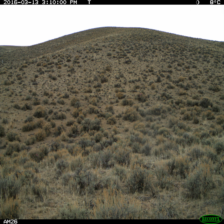

In [ ]:
from torchvision import transforms

to_pil = transforms.ToPILImage()

img = to_pil(sample)
img

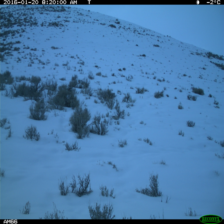

In [ ]:
transforms.ToPILImage()(train_data.fetch_image(1079485)[0])

In [ ]:
from torchvision.transforms import ToPILImage
empty_images = [train_data[i][0] for i in range(0, 100000, 10000)]
stacked = torch.stack(empty_images)
mean_image = stacked.mean(dim=0)
ToPILImage()(mean_image)
torch.save(mean_image, "mean_image_tensor.pt")

coyote deer


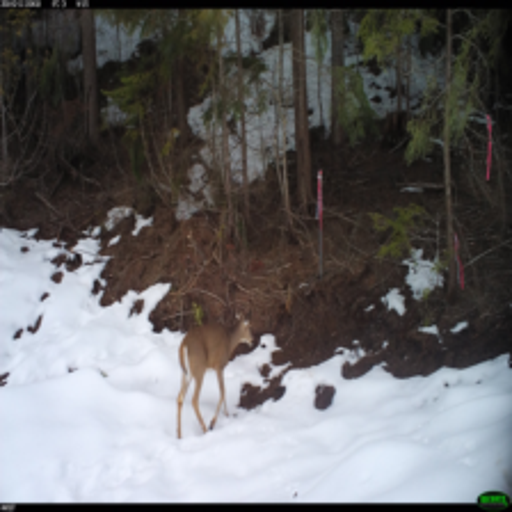

In [ ]:
sample, label = train_data[-34589]
output = model(sample.unsqueeze(0).to(device))
print(train_data.idx_to_class(torch.argmax(output, dim=1).item()), train_data.idx_to_class(label))
img = to_pil(sample)
img.resize((512, 512))

In [13]:
test_data = AnimalsDataset(test_df, categoeries)

labels = test_data.images_annotations['category_id'].tolist()
class_counts = Counter(labels)

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

labels = test_data.images_annotations['category_id'].tolist()

test_loader = DataLoader(
    test_data,
    batch_size=10
)

In [44]:
model.eval()
all_preds = []
all_labels = []

from sklearn.metrics import precision_score, recall_score, f1_score

total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        print(f"\t{total}/{len(test_loader)}")
        total += 10
        if total == len(test_loader):
          break

	0/30583
	10/30583
	20/30583
	30/30583
	40/30583
	50/30583
	60/30583
	70/30583
	80/30583
	90/30583
	100/30583
	110/30583
	120/30583
	130/30583
	140/30583
	150/30583
	160/30583
	170/30583
	180/30583
	190/30583
	200/30583
	210/30583
	220/30583
	230/30583
	240/30583
	250/30583
	260/30583
	270/30583
	280/30583
	290/30583
	300/30583
	310/30583
	320/30583
	330/30583
	340/30583
	350/30583
	360/30583
	370/30583
	380/30583
	390/30583
	400/30583
	410/30583
	420/30583
	430/30583
	440/30583
	450/30583
	460/30583
	470/30583
	480/30583
	490/30583
	500/30583
	510/30583
	520/30583
	530/30583
	540/30583
	550/30583
	560/30583
	570/30583
	580/30583
	590/30583
	600/30583
	610/30583
	620/30583
	630/30583
	640/30583
	650/30583
	660/30583
	670/30583
	680/30583
	690/30583
	700/30583
	710/30583
	720/30583
	730/30583
	740/30583
	750/30583
	760/30583
	770/30583
	780/30583
	790/30583
	800/30583
	810/30583
	820/30583
	830/30583
	840/30583
	850/30583
	860/30583
	870/30583
	880/30583
	890/30583
	900/30583
	910/30583

KeyboardInterrupt: 

In [45]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5867


In [46]:
display_labels = [test_data.idx_to_class(id) for id in np.unique(all_preds)]

In [47]:
# Compute metrics
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

len(precision), len(display_labels)

(51, 51)

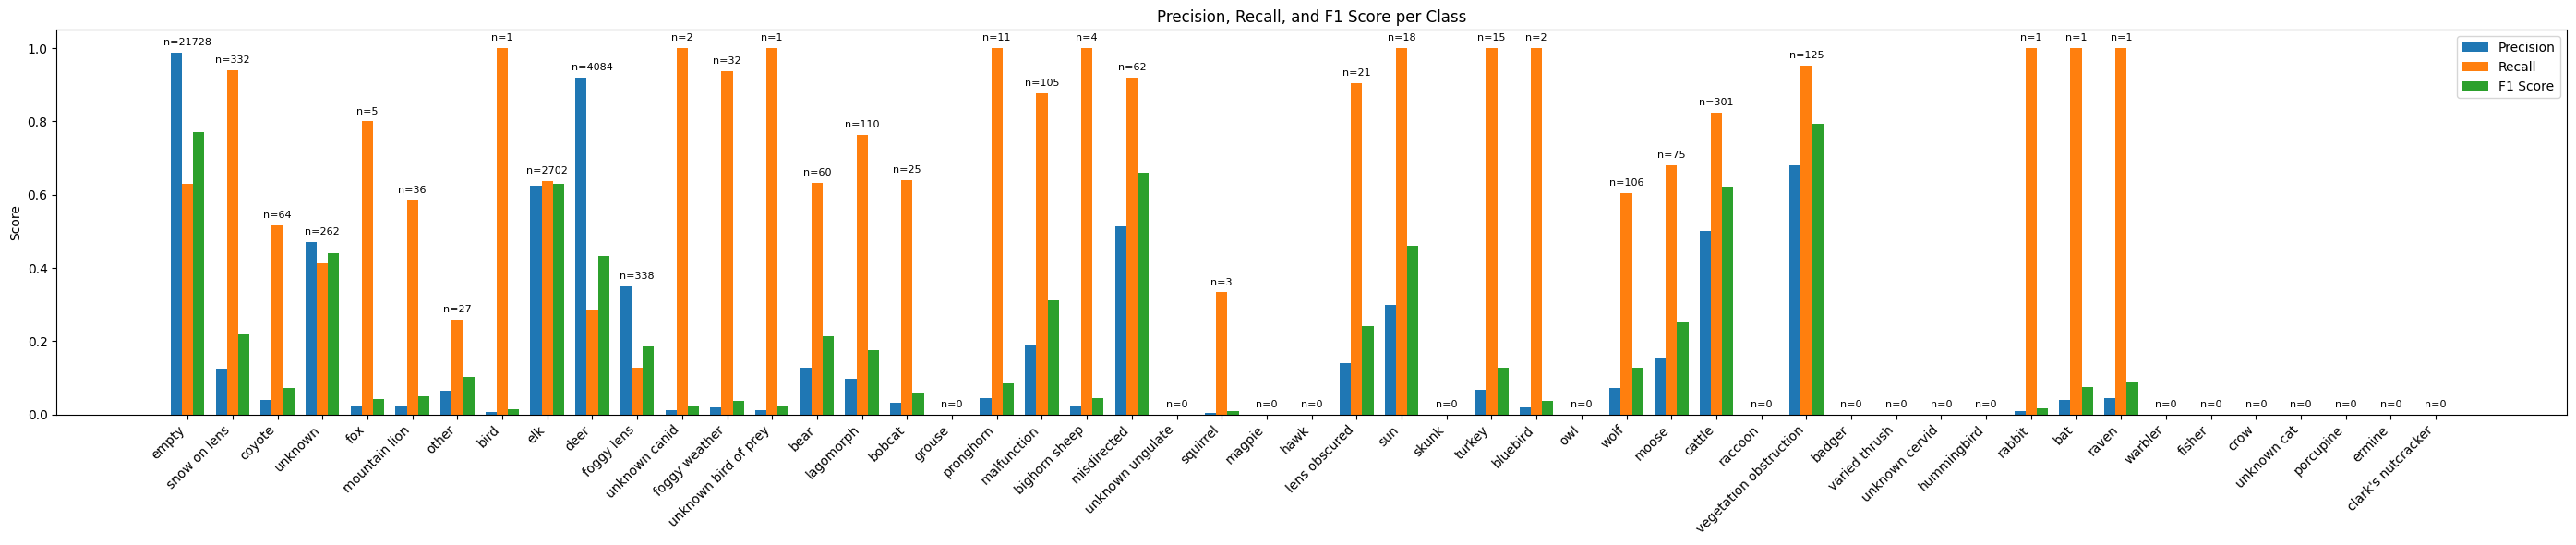

In [48]:
# Plot
x = np.arange(len(display_labels))
width = 0.25

label_counts = Counter(all_labels)
support = np.array([label_counts.get(i, 0) for i in np.unique(all_preds)])

plt.figure(figsize=(28, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

for i in x:
  plt.text(i, max(precision[i], recall[i], f1[i]) + 0.02, f'n={support[i]}', ha='center', fontsize=8)


plt.xticks(x, display_labels, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Class')
plt.legend()
plt.tight_layout()
plt.show()

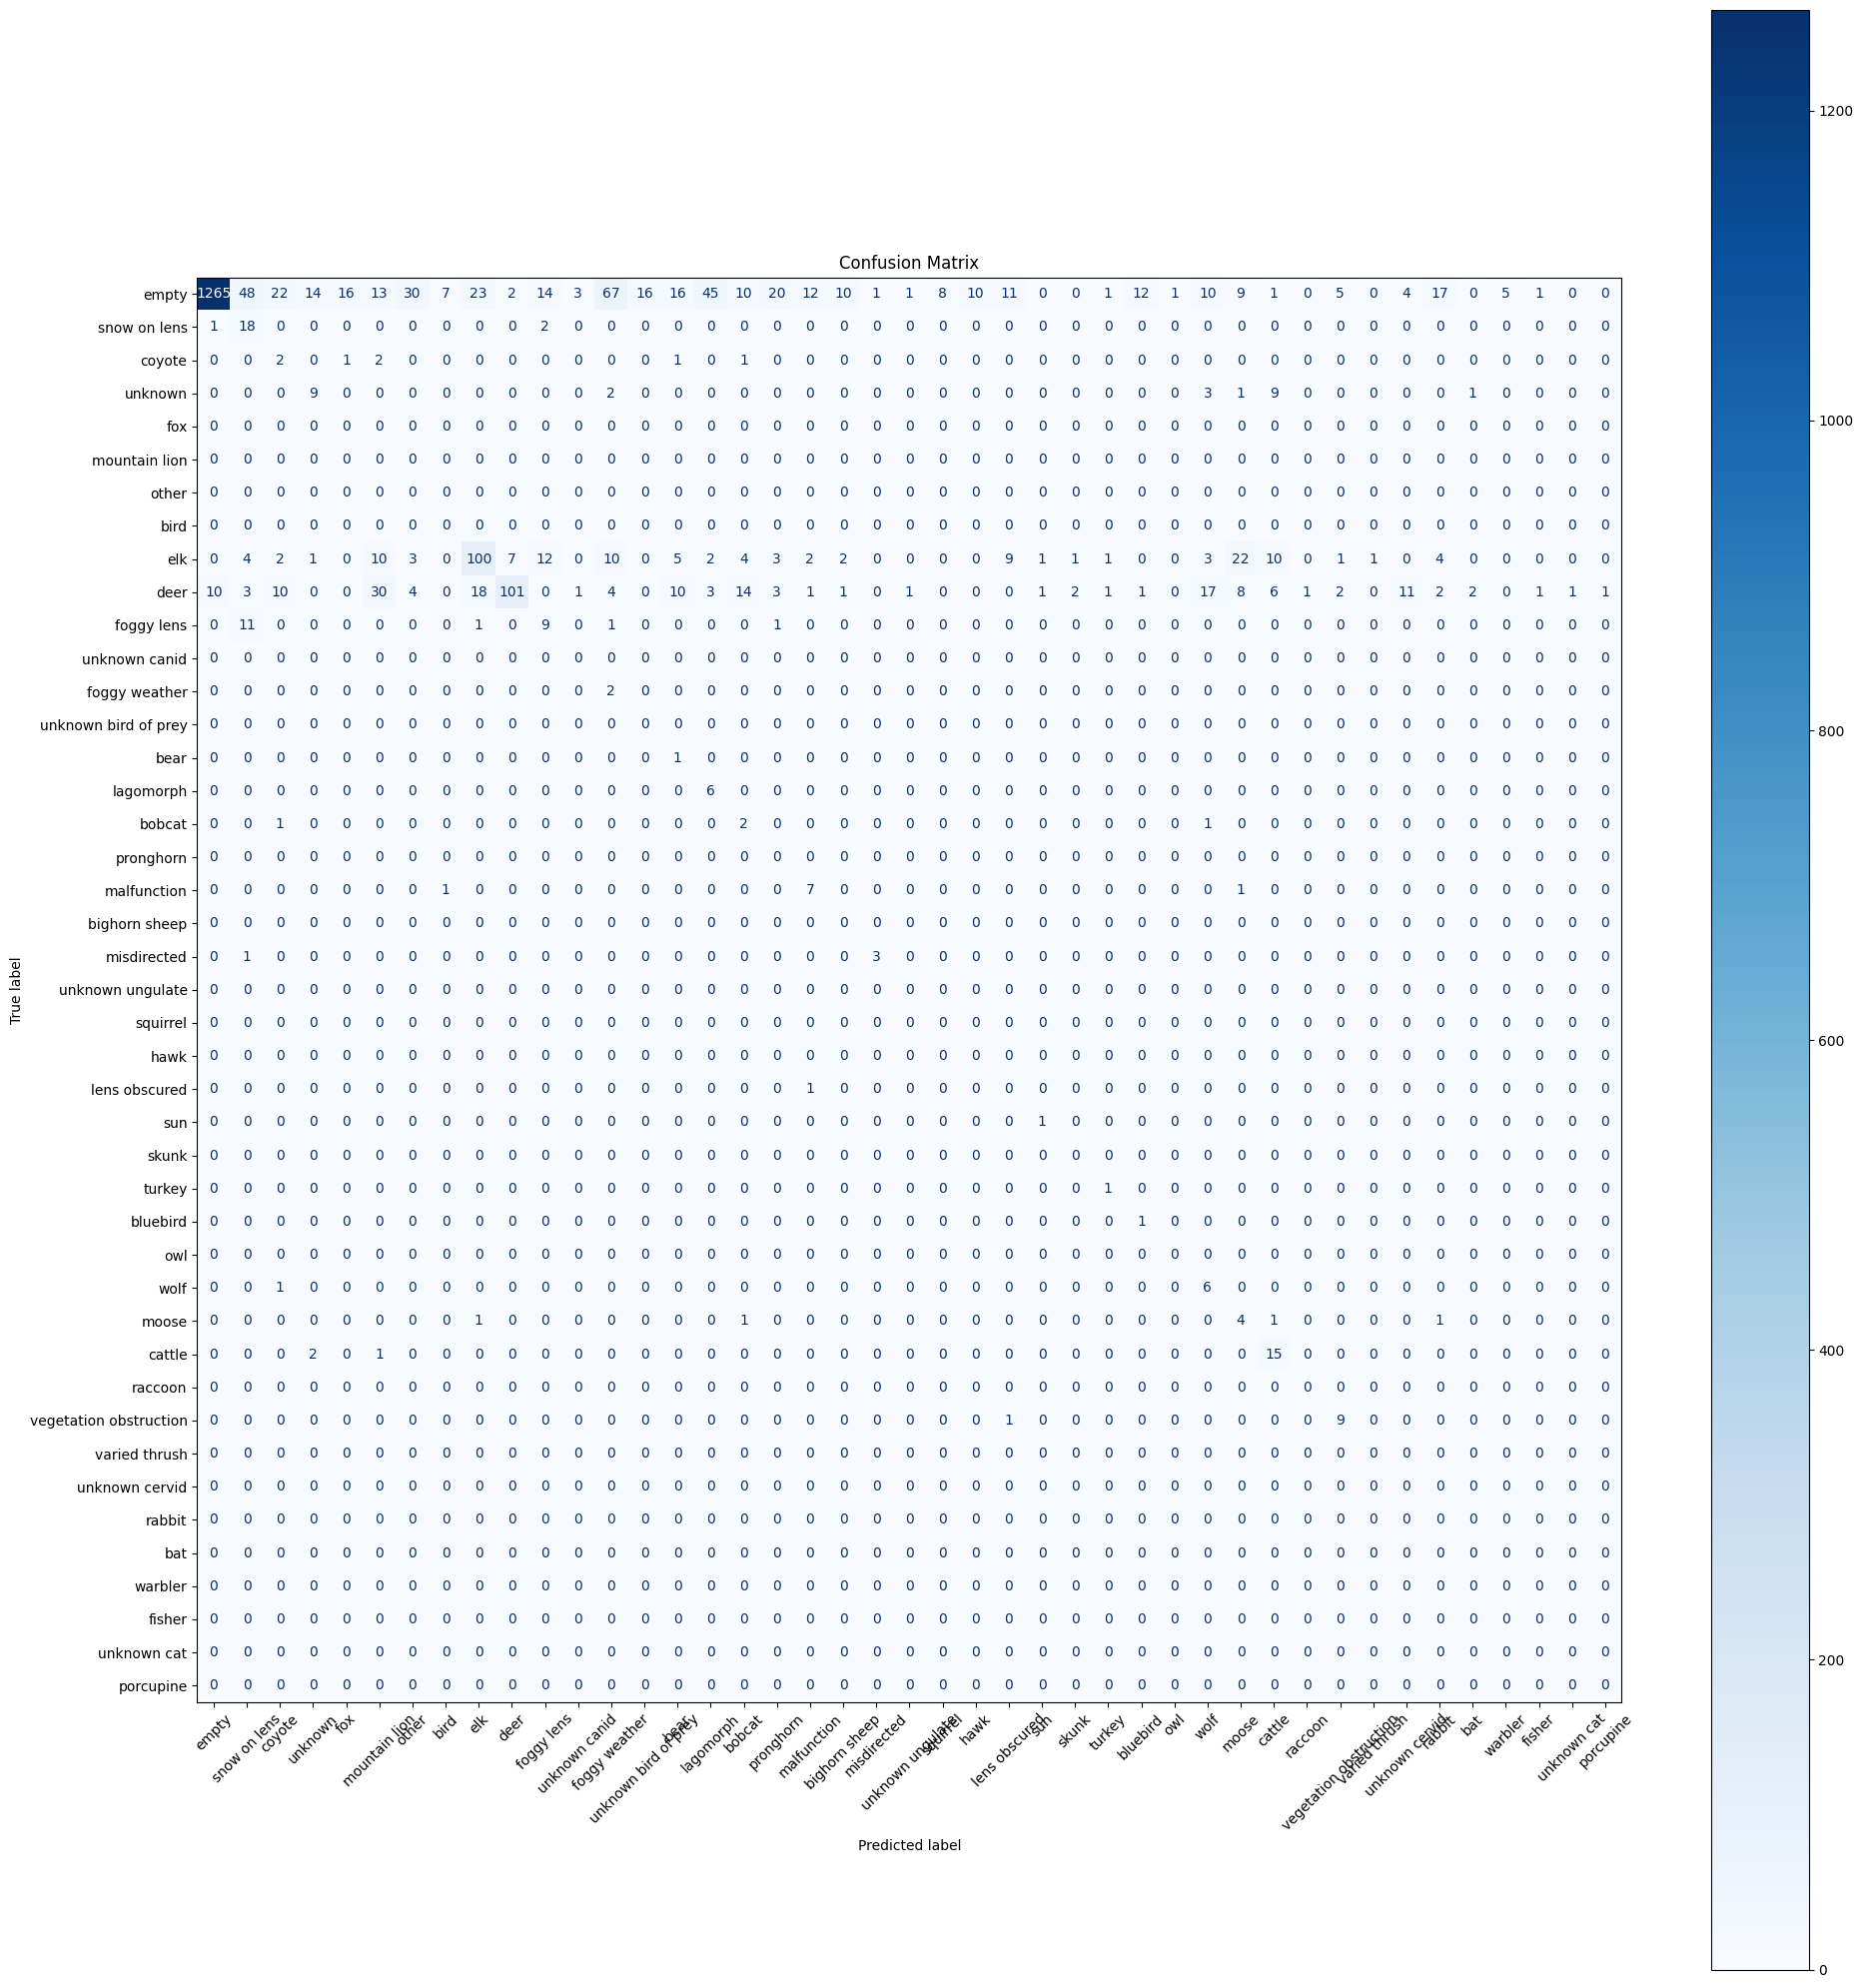

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()